# Character RNNs

In [1]:
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "2"
import tensorflow as tf

dataset_path = os.path.abspath("./datasets/nonsensical_yoda2.txt")
with open(dataset_path) as f:
    yoda_ramblings = f.read()
    print(yoda_ramblings[:100])

you must, Anger important is.
leads, You learned is.
wise Size leads, it does.
nothing, The future m


We can start off by creating our text vector, encoding the nonsensical Yoda ramblings into character level integer mappings.

In [2]:
text_vec_layer = tf.keras.layers.TextVectorization(split="character", standardize="lower")
text_vec_layer.adapt([yoda_ramblings])
encoded_ramblings = text_vec_layer([yoda_ramblings])[0] - 2 # remove padding and unknown chars

In [3]:
token_count = text_vec_layer.vocabulary_size() - 2 
dataset_size = len(encoded_ramblings)
print(f"N characters: {token_count}, Dataset size: {dataset_size}")

N characters: 28, Dataset size: 93562


Training our seq-to-seq RNN will involve configuring our dataset into pairs of input and target sequence windows. The input and target sequence window lengths will match. The target windows will contain a shifted version of the inputs, at a single time step ahead.

In [4]:
tf.random.set_seed(42)

def construct_dataset(character_seq, window_length):
    dataset = tf.data.Dataset.from_tensor_slices(character_seq)
    dataset = dataset.window(window_length + 1, shift=1, drop_remainder=True)
    dataset = dataset.flat_map(lambda window_dataset: window_dataset.batch(window_length + 1))
    
    # shuffle the dataset
    dataset = dataset.shuffle(buffer_size=100_000)
    dataset = dataset.batch(32)
    return dataset.map(lambda window: (window[:, :-1], window[:, 1:])).prefetch(1)

The above function does the following in order:
1. Convert the input sequence to a TensorFlow Dataset.
2. Construct sliding windows over the sequence with the given window length, ensuring windows are overlapping and slide by one element at a time.
3. Flatten the nested Datasets.
4. Shuffle, batch and return a Dataset of input, target pairs. Prefetch, ensuring data preprocessing is overlapped with model training one batch ahead.

In [5]:
# construct our training, validation and test set.
window_length = 50
train_set = construct_dataset(encoded_ramblings[:74800], window_length=window_length) # ~80%
valid_set = construct_dataset(encoded_ramblings[74800:84100], window_length=window_length) # ~10%
test_set = construct_dataset(encoded_ramblings[84100:], window_length=window_length) # ~10%

## What are GRUs?

The GRU (or Gated Recurrent Unit) is a variant of the LSTM cell that simplifies the architecture while achieving similar performance. This simplification is accomplished through a few key adjustments.

Firstly, the GRU eliminates the distinction between the short term state ($h_{(t)}$) and the long term state ($c_{(t)}$), opting instead to combine them into a single vector.

Secondly, the GRU architecture uses only two gates:
- **Update gate** $z_{(t)}$: This gate controlls the extent to which the previous hidden state is kept (or dropped) and how much of the new state is added (similar to the combination of the forget and input gates in an LSTM). It uses a sigmoid activation function, constraining its output between 0 and 1.
- **Reset gate** $r_{(t)}$: This gate determines how much of the previous hidden state contributes to the candidate activation $g_{(t)}$. Outputs closer to 0 enable the GRU to forget the previous state, effectively resetting itself for new input.

Finally, the GRU does not have a separate output gate like the LSTM, so the entire hidden state vector is used as the output $h_{(t)}$. This reduces the number of parameters and simplifies the computation.

In [6]:
with tf.device('/CPU:0'):
    model = tf.keras.Sequential([
        tf.keras.layers.Embedding(input_dim=token_count, output_dim=13),
        tf.keras.layers.GRU(128, return_sequences=True),
        tf.keras.layers.Dense(token_count, activation="softmax")
    ])

model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam", metrics=["accuracy"])
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    "yoda_model", monitor="val_accuracy", save_best_only=True)
history = model.fit(train_set, validation_data=valid_set, epochs=10, callbacks=[model_checkpoint])

Epoch 1/10
   2336/Unknown - 33s 12ms/step - loss: 0.6496 - accuracy: 0.7847

INFO:tensorflow:Assets written to: yoda_model/assets


INFO:tensorflow:Assets written to: yoda_model/assets


2336/2336 [==============================] - 38s 14ms/step - loss: 0.6496 - accuracy: 0.7847 - val_loss: 0.3770 - val_accuracy: 0.8555
Epoch 2/10
2336/2336 [==============================] - ETA: 0s - loss: 0.3454 - accuracy: 0.8660

INFO:tensorflow:Assets written to: yoda_model/assets


INFO:tensorflow:Assets written to: yoda_model/assets


2336/2336 [==============================] - 36s 14ms/step - loss: 0.3454 - accuracy: 0.8660 - val_loss: 0.3613 - val_accuracy: 0.8595
Epoch 3/10
2336/2336 [==============================] - 35s 13ms/step - loss: 0.3306 - accuracy: 0.8705 - val_loss: 0.3627 - val_accuracy: 0.8589
Epoch 4/10
2336/2336 [==============================] - 34s 13ms/step - loss: 0.3208 - accuracy: 0.8744 - val_loss: 0.3758 - val_accuracy: 0.8552
Epoch 5/10
2336/2336 [==============================] - 35s 13ms/step - loss: 0.3115 - accuracy: 0.8785 - val_loss: 0.3766 - val_accuracy: 0.8576
Epoch 6/10
2336/2336 [==============================] - 35s 13ms/step - loss: 0.3027 - accuracy: 0.8827 - val_loss: 0.3901 - val_accuracy: 0.8554
Epoch 7/10
2336/2336 [==============================] - 35s 13ms/step - loss: 0.2948 - accuracy: 0.8861 - val_loss: 0.3960 - val_accuracy: 0.8561
Epoch 8/10
2336/2336 [==============================] - 35s 13ms/step - loss: 0.2882 - accuracy: 0.8889 - val_loss: 0.4036 - val_accura

The above does the following:
- Encodes the character IDs as embeddings. The input dimension will be the count of distinct characters we have in our dataset and the output dimension will a tunable hyperparameter (fixed at 13 for now). The output is a series of 13 dimensional embedding vectors representing each character.
- Passes the outputs of the Embedding layer to the GRU, configured with 128 units.
  - Each time step, each cell processes the entire input sequence, maintaining its own input state.
  - `return_sequences=True` means the layer outputs a sequence of hidden states, 1 for each time step in the input sequence. This results in a 3D tensor of shape [batch size, window length, GRU units] or [32, 50, 128].
- Uses a Dense layer with softmax activation to output character probabilities, applied at each time step independently. This layer is configured with the same amount of units as distinct characters in our dataset.
- Compiles the model using the sparse categorical crossentropy loss, and the Nadam optimizer. We'll use the ModelCheckpoint callback to save the best performing model based on the validation set accuracy between epochs. This will help us preserve the model with the best validation performance in case of fluctuations during training, or overfitting begins to occur.

Finally, let's wrap the preprocessing up in a final model for inferencing:

In [7]:
final_model = tf.keras.Sequential([
    text_vec_layer,
    tf.keras.layers.Lambda(lambda X: X - 2), # remove padding and unknown chars as before
    model
])

In [8]:
y_proba = final_model.predict(["strong, The dark side i"])[0, -1]
y_pred = tf.argmax(y_proba) # highest character probability
text_vec_layer.get_vocabulary()[y_pred + 2]

1/1 [==============================] - 0s 464ms/step


's'

## Temperature-controlled Sampling

A typical approach to text generation from here would be to iteratively generate and append new characters to the end of a character sequence. This is through the following steps:

1. **Model prediction**: Obtain the predicted probability distribution for the last time step.
2. **Apply temperature**: Convert the predicted probabilities into logits (using `tf.math.log`) and rescale them by dividing by a _temperature_ parameter. This parameter controls the randomness of predictions - lower temperatures make the model more confident (less random), while higher temperatures make it more exploratory (more random).
3. **Sampling**: Using the probabilities defined by the rescaled logits, sample the next character ID using `tf.random.categorical`.

In [9]:
def next_char(text, temp=1):
    y_proba = final_model.predict([text], verbose=0)[0, -1:] # 1.
    rescaled_logits = tf.math.log(y_proba) / temp # 2.
    y_pred = tf.random.categorical(rescaled_logits, num_samples=1)[0, 0] #3.
    return text_vec_layer.get_vocabulary()[y_pred + 2]
    
def produce_text(text, num_characters=140, temp=1):
    for _ in range(num_characters):
        text += next_char(text, temp)
    return text

print(produce_text("strong, The dark side is"))

strong, The dark side is.
always is there impossible, the future is.
strong, the future cannot, hmm.
dangerous, a jedi is, hmm.
everything, you leads, hmm.
everythi


In [10]:
print(produce_text("strong, The dark side is", temp=3))

strong, The dark side is, size clouded is.
alway.ng, fhmu,arndt size understande clouded knowlleng.
size you training must, it roes.
to you are, a jeri must.
s,aii 


Introducing further control over the sampled characters by selecting the next token from the smallest subset of tokens whose cumulative probability exceeds a specific threshold will help avoid generating completely unconvincing text like the above. In fact, this technique is called _nucleus sampling_, but we can go one step further, and use a stateful RNN.

## Stateful RNNs

If we preserve the hidden state across different batches of input sequences during training (as opposed to resetting them to zeros between batches), we can enable the network to maintain context over large sequences split across multiple batches. Note backpropagation through time (BPTT) will still be limited to the sequence length of a single batch.

For that though, we'll need a better suited dataset. We'll use the Star Wars original trilogy scripts.

In [11]:
dataset_path = os.path.abspath("./datasets/original_trilogy_scripts.txt")

with open(dataset_path) as f:
    sw_script = f.read()
    print(sw_script[:33])
    print("...")
    print(sw_script[-27:])

STAR WARS

Episode IV

A NEW HOPE
...
END CREDITS OVER STAR FIELD


In [12]:
text_vec_layer = tf.keras.layers.TextVectorization(split="character", standardize="lower")
text_vec_layer.adapt([sw_script])
encoded_script = text_vec_layer([sw_script])[0] - 2 # remove padding and unknown chars

token_count = text_vec_layer.vocabulary_size() - 2 
dataset_size = len(sw_script)
print(f"N characters: {token_count}, Dataset size: {dataset_size}")

N characters: 55, Dataset size: 490580


Overlapping and shuffled input sequences will no longer do. The following are the newly constructed datasets using a revised version of the `construct_dataset` method.

In [13]:
tf.random.set_seed(42)

def construct_stateful_dataset(character_seq, window_length):
    dataset = tf.data.Dataset.from_tensor_slices(character_seq)
    dataset = dataset.window(window_length + 1, shift=window_length, drop_remainder=True)
    dataset = dataset.flat_map(lambda window_dataset: window_dataset.batch(window_length + 1))
    
    dataset = dataset.batch(1)
    return dataset.map(lambda window: (window[:, :-1], window[:, 1:])).prefetch(1)

window_length = 100
train_set = construct_stateful_dataset(encoded_script[:392400], window_length) # ~80%
valid_set = construct_stateful_dataset(encoded_script[392400:441500], window_length) # ~10%
test_set = construct_stateful_dataset(encoded_script[441500:], window_length) # ~10%

Then constructing the stateful RNN is easy, with few small adjustments. We just ensure the batch input size is set in the first layer, and the `stateful=True` is set on the GRU layer. It's also important to wipe the hidden state between training epochs to avoid unintended carryover of information from the last batch of the previous epoch. This will ensure each epoch maintains it's own context, and doesn't mix sequential data across epochs. We can achieve this with a very simple callback.

In [14]:
with tf.device('/CPU:0'):
    model = tf.keras.Sequential([
        tf.keras.layers.Embedding(input_dim=token_count, output_dim=16, batch_input_shape=[1, None]),
        tf.keras.layers.GRU(128, return_sequences=True, stateful=True),
        tf.keras.layers.Dense(token_count, activation="softmax")
    ])

class ModelResetStatesCallback(tf.keras.callbacks.Callback):
    def on_epoch_begin(self, epoch, logs):
        self.model.reset_states()
        
model.compile(loss="sparse_categorical_crossentropy", optimizer="nadam", metrics=["accuracy"])

model_checkpoint = tf.keras.callbacks.ModelCheckpoint(
    "sw_model", monitor="val_accuracy", save_best_only=True)
model_callbacks = [ModelResetStatesCallback(), model_checkpoint]

history = model.fit(train_set, validation_data=valid_set, epochs=15, callbacks=model_callbacks)

Epoch 1/15
   3920/Unknown - 64s 16ms/step - loss: 2.0927 - accuracy: 0.3982

INFO:tensorflow:Assets written to: sw_model/assets


INFO:tensorflow:Assets written to: sw_model/assets


3923/3923 [==============================] - 70s 18ms/step - loss: 2.0925 - accuracy: 0.3982 - val_loss: 1.9235 - val_accuracy: 0.4379
Epoch 2/15
3923/3923 [==============================] - ETA: 0s - loss: 1.6507 - accuracy: 0.5104

INFO:tensorflow:Assets written to: sw_model/assets


INFO:tensorflow:Assets written to: sw_model/assets


3923/3923 [==============================] - 69s 18ms/step - loss: 1.6507 - accuracy: 0.5104 - val_loss: 1.7565 - val_accuracy: 0.4781
Epoch 3/15
3922/3923 [============================>.] - ETA: 0s - loss: 1.5008 - accuracy: 0.5508

INFO:tensorflow:Assets written to: sw_model/assets


INFO:tensorflow:Assets written to: sw_model/assets


3923/3923 [==============================] - 68s 17ms/step - loss: 1.5009 - accuracy: 0.5508 - val_loss: 1.6856 - val_accuracy: 0.4998
Epoch 4/15
3922/3923 [============================>.] - ETA: 0s - loss: 1.4239 - accuracy: 0.5722

INFO:tensorflow:Assets written to: sw_model/assets


INFO:tensorflow:Assets written to: sw_model/assets


3923/3923 [==============================] - 68s 17ms/step - loss: 1.4240 - accuracy: 0.5722 - val_loss: 1.6451 - val_accuracy: 0.5117
Epoch 5/15
3921/3923 [============================>.] - ETA: 0s - loss: 1.3767 - accuracy: 0.5844

INFO:tensorflow:Assets written to: sw_model/assets


INFO:tensorflow:Assets written to: sw_model/assets


3923/3923 [==============================] - 69s 18ms/step - loss: 1.3768 - accuracy: 0.5843 - val_loss: 1.6250 - val_accuracy: 0.5181
Epoch 6/15
3922/3923 [============================>.] - ETA: 0s - loss: 1.3435 - accuracy: 0.5933

INFO:tensorflow:Assets written to: sw_model/assets


INFO:tensorflow:Assets written to: sw_model/assets


3923/3923 [==============================] - 68s 17ms/step - loss: 1.3436 - accuracy: 0.5933 - val_loss: 1.6150 - val_accuracy: 0.5214
Epoch 7/15
3922/3923 [============================>.] - ETA: 0s - loss: 1.3187 - accuracy: 0.6003

INFO:tensorflow:Assets written to: sw_model/assets


INFO:tensorflow:Assets written to: sw_model/assets


3923/3923 [==============================] - 69s 18ms/step - loss: 1.3188 - accuracy: 0.6003 - val_loss: 1.6074 - val_accuracy: 0.5246
Epoch 8/15
3921/3923 [============================>.] - ETA: 0s - loss: 1.2993 - accuracy: 0.6052

INFO:tensorflow:Assets written to: sw_model/assets


INFO:tensorflow:Assets written to: sw_model/assets


3923/3923 [==============================] - 69s 17ms/step - loss: 1.2994 - accuracy: 0.6052 - val_loss: 1.6026 - val_accuracy: 0.5277
Epoch 9/15
3923/3923 [==============================] - ETA: 0s - loss: 1.2839 - accuracy: 0.6097

INFO:tensorflow:Assets written to: sw_model/assets


INFO:tensorflow:Assets written to: sw_model/assets


3923/3923 [==============================] - 68s 17ms/step - loss: 1.2839 - accuracy: 0.6097 - val_loss: 1.6000 - val_accuracy: 0.5280
Epoch 10/15
3922/3923 [============================>.] - ETA: 0s - loss: 1.2712 - accuracy: 0.6130

INFO:tensorflow:Assets written to: sw_model/assets


INFO:tensorflow:Assets written to: sw_model/assets


3923/3923 [==============================] - 69s 18ms/step - loss: 1.2714 - accuracy: 0.6130 - val_loss: 1.5973 - val_accuracy: 0.5291
Epoch 11/15
3923/3923 [==============================] - ETA: 0s - loss: 1.2614 - accuracy: 0.6158

INFO:tensorflow:Assets written to: sw_model/assets


INFO:tensorflow:Assets written to: sw_model/assets


3923/3923 [==============================] - 68s 17ms/step - loss: 1.2614 - accuracy: 0.6158 - val_loss: 1.5959 - val_accuracy: 0.5308
Epoch 12/15
3923/3923 [==============================] - ETA: 0s - loss: 1.2531 - accuracy: 0.6180

INFO:tensorflow:Assets written to: sw_model/assets


INFO:tensorflow:Assets written to: sw_model/assets


3923/3923 [==============================] - 69s 18ms/step - loss: 1.2531 - accuracy: 0.6180 - val_loss: 1.5948 - val_accuracy: 0.5326
Epoch 13/15
3923/3923 [==============================] - 67s 17ms/step - loss: 1.2457 - accuracy: 0.6198 - val_loss: 1.5943 - val_accuracy: 0.5321
Epoch 14/15
3923/3923 [==============================] - 67s 17ms/step - loss: 1.2397 - accuracy: 0.6209 - val_loss: 1.5983 - val_accuracy: 0.5323
Epoch 15/15
3921/3923 [============================>.] - ETA: 0s - loss: 1.2343 - accuracy: 0.6224

INFO:tensorflow:Assets written to: sw_model/assets


INFO:tensorflow:Assets written to: sw_model/assets


3923/3923 [==============================] - 69s 17ms/step - loss: 1.2344 - accuracy: 0.6224 - val_loss: 1.5977 - val_accuracy: 0.5329


We will need to inference this model using the same input length as the batch size (in this case, 1) because the hidden states are explicitly tied to the batch size. So, instead we can copy the learned weights over to a stateless model to allow more flexible model inferencing.

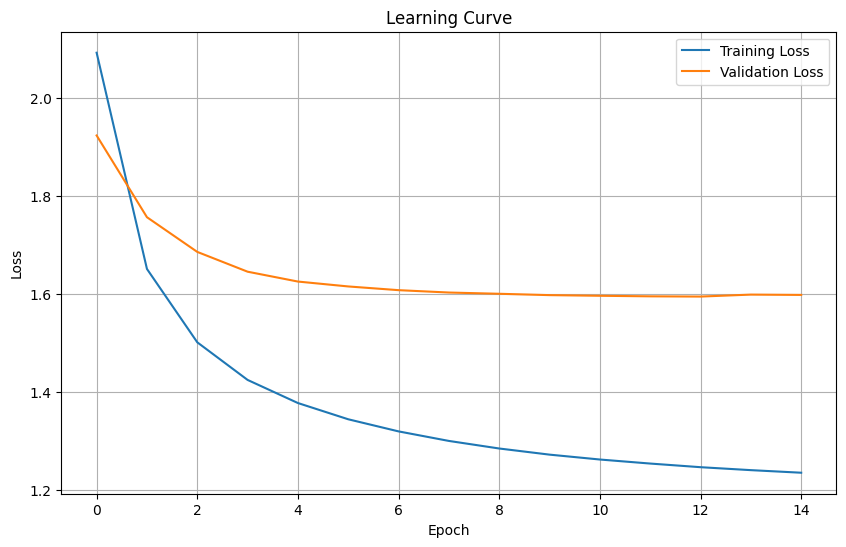

In [15]:
import matplotlib.pyplot as plt

# plot the learning curves (training and validation loss)
def plot_curve(history):
    plt.figure(figsize=(10, 6))
    
    # Plot training & validation loss values
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    
    # Adding labels and title
    plt.title('Learning Curve')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(loc='upper right')
    
    plt.grid(True)
    plt.show()

plot_curve(history)

In [16]:
converted_model = tf.keras.Sequential([
    tf.keras.layers.Embedding(input_dim=token_count, output_dim=16),
    tf.keras.layers.GRU(128, return_sequences=True),
    tf.keras.layers.Dense(token_count, activation="softmax")
])

# build the model, create the weight matrices and copy over the learnt weights.
converted_model.build(tf.TensorShape([None, None])) 
converted_model.set_weights(model.get_weights())

final_model = tf.keras.Sequential([
    text_vec_layer,
    tf.keras.layers.Lambda(lambda X: X - 2), # remove padding and unknown chars as before
    converted_model
])

In [25]:
# copy of earlier functions for convenience
def next_char(text, temp=1):
    y_proba = final_model.predict([text], verbose=0)[0, -1:] # 1.
    rescaled_logits = tf.math.log(y_proba) / temp # 2.
    y_pred = tf.random.categorical(rescaled_logits, num_samples=1)[0, 0] #3.
    return text_vec_layer.get_vocabulary()[y_pred + 2]
    
def produce_text(text, num_characters=140, temp=1):
    for _ in range(num_characters):
        text += next_char(text, temp)
    return text

print(produce_text("Luke Sky", temp=0.6))

Luke Skywalker 
and the deck see you with an old of the distance side of the cable 
and the contatle of the patter to his hand, with make in the dan
